## Prédiction des émissions de CO2 et energie totale  pour anticipez les besoins en consommation de bâtiments
#### Auteur: SACKO Alseny

#### Librairie nécessaire pour le travail

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import missingno as mno
from sklearn.compose import make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing 
from sklearn.preprocessing import MinMaxScaler
from sklearn import utils
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from category_encoders import TargetEncoder
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection  import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import learning_curve

# INPORTATION DES DONNEES

In [96]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns',None)

In [97]:
data_energy = pd.read_csv(r'C:\Users\pc\Documents\projet.3.O.C.Rnew\Donnees\dataSetEnergy.csv')

In [98]:
df_energy = data_energy.copy()
df_energy.head()

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofFloors,PropertyGFATotal,PropertyGFAParking,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUseWN(kBtu),SteamUse(kBtu),NaturalGas(kBtu),TotalGHGEmissions
0,NonResidential,Hotel,DOWNTOWN,1927,12,88434,0,88434.0,60.0,7456910.0,2003882.00,1276453.0,249.98
1,NonResidential,Hotel,DOWNTOWN,1996,11,103566,15064,83880.0,61.0,8664479.0,0.00,5145082.0,295.86
2,NonResidential,Hotel,DOWNTOWN,1969,41,956110,196718,756493.0,43.0,73937112.0,21566554.00,1493800.0,2089.28
3,NonResidential,Hotel,DOWNTOWN,1926,10,61320,0,61320.0,56.0,6946800.5,2214446.25,1811213.0,286.43
4,NonResidential,Hotel,DOWNTOWN,1980,18,175580,62000,123445.0,75.0,14656503.0,0.00,8803998.0,505.01


In [99]:
df_energy.shape

(3376, 13)

### Feature engineering

In [100]:
def consoenergy(data_energy):
    if data_energy["SteamUse(kBtu)"] >=1:
        return 1
    else:
        return 0

In [101]:
data_energy["UtiliseVapeur"] = data_energy.apply(consoenergy, axis=1)

In [102]:
def consogaz(data_energy):
    if data_energy["NaturalGas(kBtu)"] > 1:
        return 1
    else:
        return 0   

In [103]:
data_energy["UtiliseNturalGas"] = data_energy.apply(consogaz, axis=1)

In [104]:
data_energy.drop(["SteamUse(kBtu)", "NaturalGas(kBtu)"], axis=1, inplace = True)

In [136]:
df_energy = data_energy.copy()
df_energy.head(10)

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofFloors,PropertyGFATotal,PropertyGFAParking,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUseWN(kBtu),TotalGHGEmissions,UtiliseVapeur,UtiliseNturalGas
0,NonResidential,Hotel,DOWNTOWN,1927,12,88434,0,88434.0,60.0,7456910.0,249.98,1,1
1,NonResidential,Hotel,DOWNTOWN,1996,11,103566,15064,83880.0,61.0,8664479.0,295.86,0,1
2,NonResidential,Hotel,DOWNTOWN,1969,41,956110,196718,756493.0,43.0,73937112.0,2089.28,1,1
3,NonResidential,Hotel,DOWNTOWN,1926,10,61320,0,61320.0,56.0,6946800.5,286.43,1,1
4,NonResidential,Hotel,DOWNTOWN,1980,18,175580,62000,123445.0,75.0,14656503.0,505.01,0,1
5,Nonresidential COS,Other,DOWNTOWN,1999,2,97288,37198,88830.0,NaN,12581712.0,301.81,0,1
6,NonResidential,Hotel,DOWNTOWN,1926,11,83008,0,81352.0,27.0,6062767.5,176.14,0,1
7,NonResidential,Other,DOWNTOWN,1926,8,102761,0,102761.0,NaN,7067881.5,221.51,1,1
8,NonResidential,Hotel,DOWNTOWN,1904,15,163984,0,163984.0,43.0,14194054.0,392.16,0,1
9,Multifamily MR (5-9),Mid-Rise Multifamily,DOWNTOWN,1910,6,63712,1496,56132.0,1.0,4807679.5,151.12,1,1


## Preprocessing

#### TrainTest - Encoage - Nettoyage

In [106]:
trainset, testset = train_test_split(df_energy, test_size = 0.2 , random_state=10)

### Encodage des variables qualitatives

In [107]:
def encodage(df_energy):
    encoder_Neighborhood = TargetEncoder()
    encoder_PrimaryPropertyType = TargetEncoder()
    encoder_BuildingType = TargetEncoder()

    encoder_Neighborhood.fit(trainset["Neighborhood"], trainset["TotalGHGEmissions"])
    trainset["Neighborhood"]= encoder_Neighborhood.transform(trainset["Neighborhood"])
    testset["Neighborhood"]= encoder_Neighborhood.transform(testset["Neighborhood"])

    encoder_PrimaryPropertyType.fit(trainset["PrimaryPropertyType"], trainset["TotalGHGEmissions"])
    trainset["PrimaryPropertyType"]= encoder_PrimaryPropertyType.transform(trainset["PrimaryPropertyType"])
    testset["PrimaryPropertyType"]= encoder_PrimaryPropertyType.transform(testset["PrimaryPropertyType"])

    encoder_BuildingType.fit(trainset["BuildingType"], trainset["TotalGHGEmissions"])
    trainset["BuildingType"]= encoder_BuildingType.transform(trainset["BuildingType"])
    testset["BuildingType"]= encoder_BuildingType.transform(testset["BuildingType"])
    return df_energy

### Suppression des valeurs abérantes¶

In [108]:
from statistics import*
from numpy import nan

In [109]:
median = float(df_energy['NumberofFloors'].median())
df_energy['NumberofFloors'] = np.where(df_energy['NumberofFloors']  > median, median, df_energy['NumberofFloors'] )

median = float(df_energy['PropertyGFATotal'].median())
df_energy['PropertyGFATotal'] = np.where(df_energy['PropertyGFATotal'] > median, median, df_energy['PropertyGFATotal'] )

median = float(df_energy['PropertyGFAParking'].median())
df_energy['PropertyGFAParking'] = np.where(df_energy['PropertyGFAParking']  > median, median, df_energy['PropertyGFAParking'] )

median = float(df_energy['LargestPropertyUseTypeGFA'].median())
df_energy['LargestPropertyUseTypeGFA'] = np.where(df_energy['LargestPropertyUseTypeGFA']  > median, median, df_energy['LargestPropertyUseTypeGFA'] )

median = float(df_energy['SiteEnergyUseWN(kBtu)'].median())
df_energy['SiteEnergyUseWN(kBtu)'] = np.where(df_energy['SiteEnergyUseWN(kBtu)']  > median, median, df_energy['SiteEnergyUseWN(kBtu)'] )

median = float(df_energy['TotalGHGEmissions'].median())
df_energy['TotalGHGEmissions'] = np.where(df_energy['TotalGHGEmissions']  > median, median, df_energy['TotalGHGEmissions'] )

In [110]:
##Suppression des lignes où quantité totale d'émissions de gaz à effet de serre,y compris le dioxyde de carbone <= à zéros
def removed(df_energy):
    df_energy = df_energy.drop(index=df_energy[df_energy['TotalGHGEmissions']<=0].index)
##Suppression des modalités(Multifamily LR (1-4),Multifamily MR (5-9), Multifamily HR (10+)) pour la colonne BuildingType
    df_energy = df_energy.drop(index=df_energy[df_energy['BuildingType']=='Multifamily HR (10+)'].index)
    df_energy = df_energy.drop(index=df_energy[df_energy['BuildingType']=='Multifamily MR (5-9)'].index)
    df_energy = df_energy.drop(index=df_energy[df_energy['BuildingType']=='Multifamily LR (1-4)'].index)
    
    return df_energy

### Imputation des valeurs manquantes

In [111]:
def imputation(df_energy):
    return df_energy.dropna(axis=0)

In [112]:
#def imputation(df_energy):
   # return df_energy.fillna(-999)

In [138]:
df_energy = imputation(df_energy)

<AxesSubplot:>

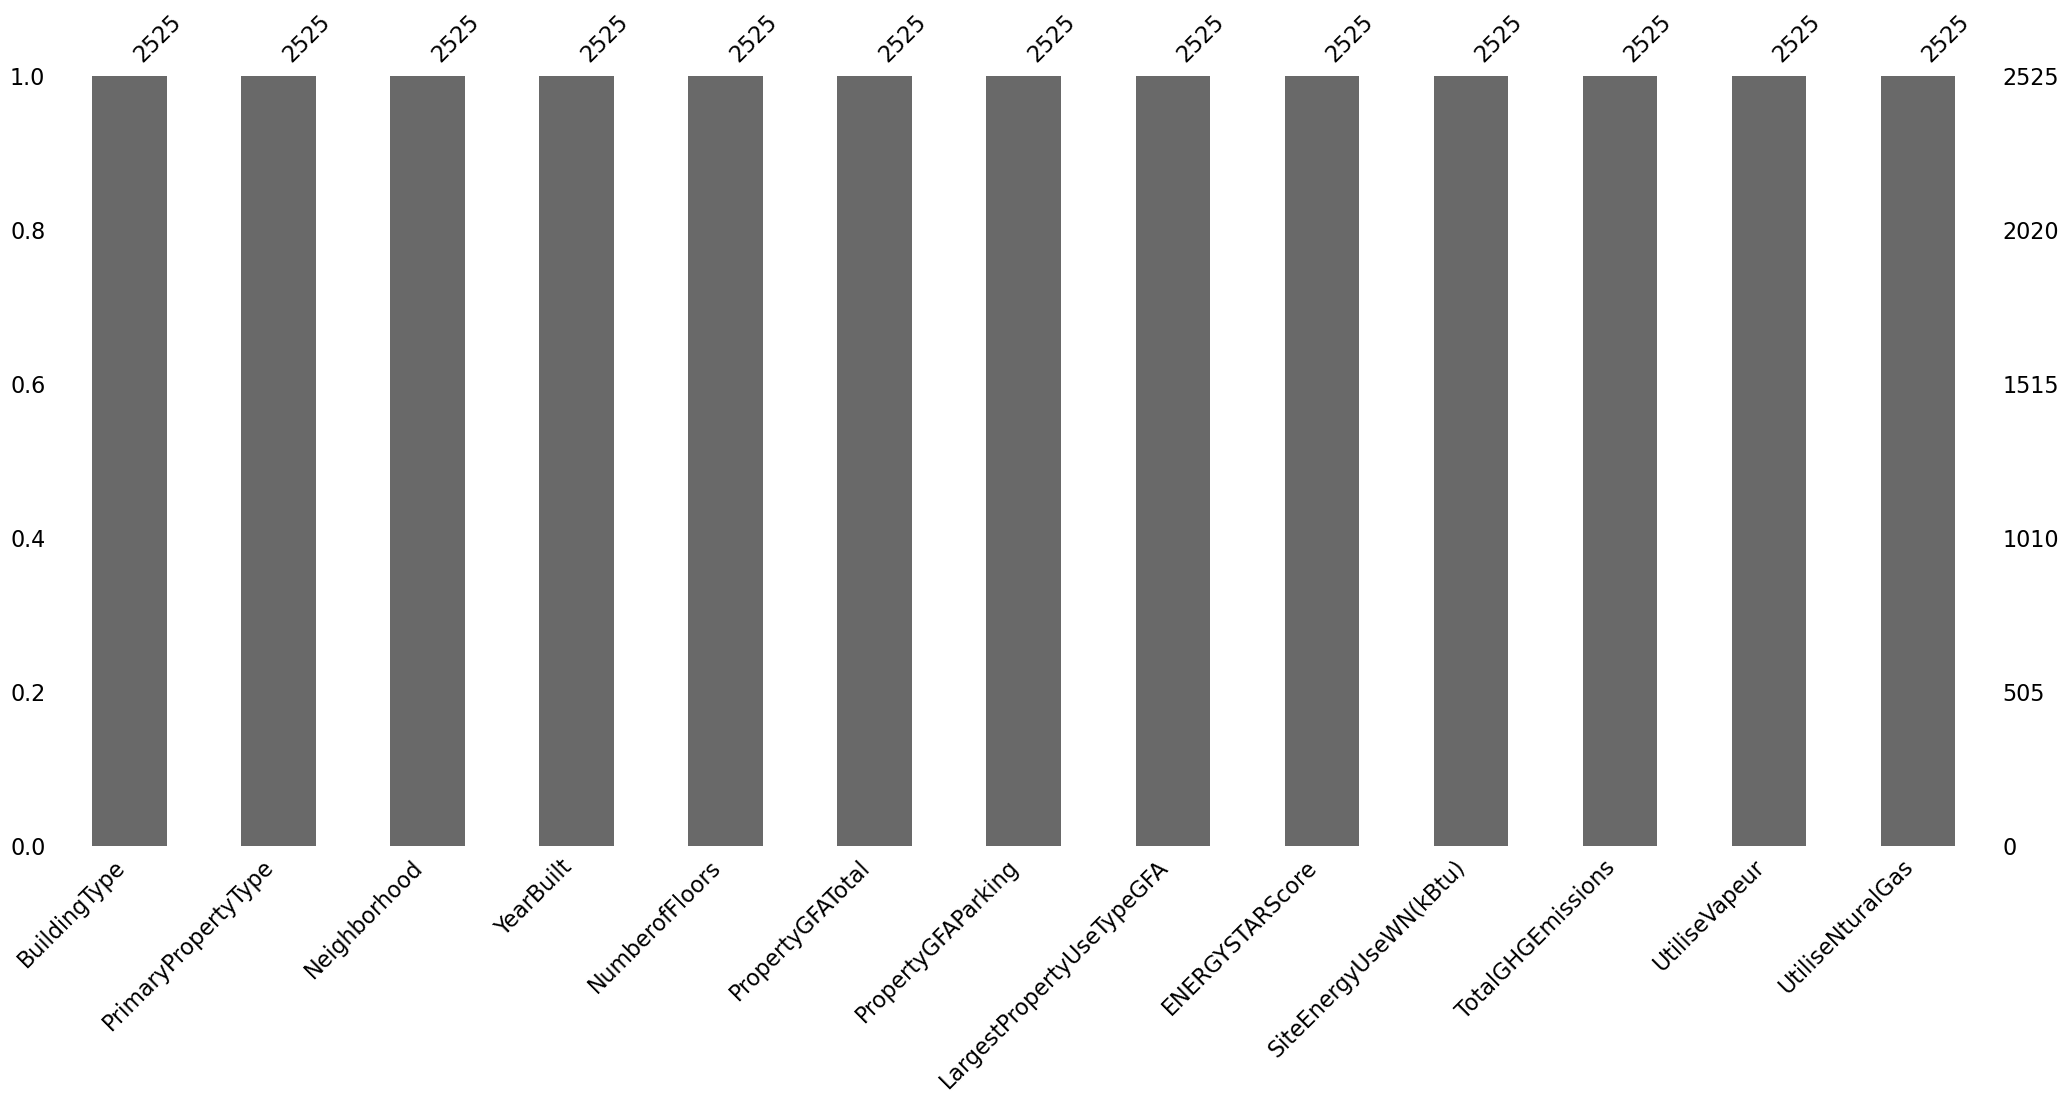

In [139]:
mno.bar(df_energy)

## Modélisation

In [113]:
def preprocessing(df_energy):
    df_energy = encodage(df_energy)
    df_energy = removed(df_energy)
    df_energy = imputation(df_energy)
    X = df_energy.drop(["TotalGHGEmissions","SiteEnergyUseWN(kBtu)"], axis = 1)
    y = df_energy["SiteEnergyUseWN(kBtu)"]
    return X, y

In [114]:
X_train, y_train = preprocessing(trainset)

In [115]:
X_train.shape

(1998, 11)

In [116]:
y_train.shape

(1998,)

In [117]:
X_test, y_test = preprocessing(testset)

In [118]:
X_test.shape

(523, 11)

In [119]:
y_test.shape

(523,)

### Instanciation du modèle

In [120]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [121]:
model = make_pipeline(PolynomialFeatures(2), SelectKBest(k=7, score_func=f_regression), RandomForestRegressor(random_state = 100))

## Conception et dianostique des modèles avec learning_curve

In [122]:
from sklearn.model_selection import learning_curve
import sklearn.metrics as metrics

In [123]:
def evaluation(model):
    model.fit(X_train, y_train.values.ravel())
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test.values.ravel(), predictions)
   #Erreur quadratique moyenne (MSE)
    mse = mean_squared_error(y_test.values.ravel(), predictions)
   #Scores-R au carré
    r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
    print('Mean Absolute Error:', round(mae, 2))
    print('Mean Squared Error:', round(mse, 2))
    print('R-squared scores:', round(r2, 2))
    N, train_score, val_score = learning_curve(model, X_train, y_train, 
                                        cv=10, scoring = 'neg_mean_squared_error',
                                        train_sizes = np.linspace(0.1, 1, 10))
    plt.figure(figsize=(12, 8))
    plt.plot(N, -train_score.mean(axis = 1), label='train_score')
    plt.plot(N, -val_score.mean(axis = 1), label='val_score')
   # plt.ylabel('MSE', fontsize = 14)
   # plt.xlabel('Training set size', fontsize = 14)
    plt.legend()

Mean Absolute Error: 1552828.33
Mean Squared Error: 10716993794087.94
R-squared scores: 0.69


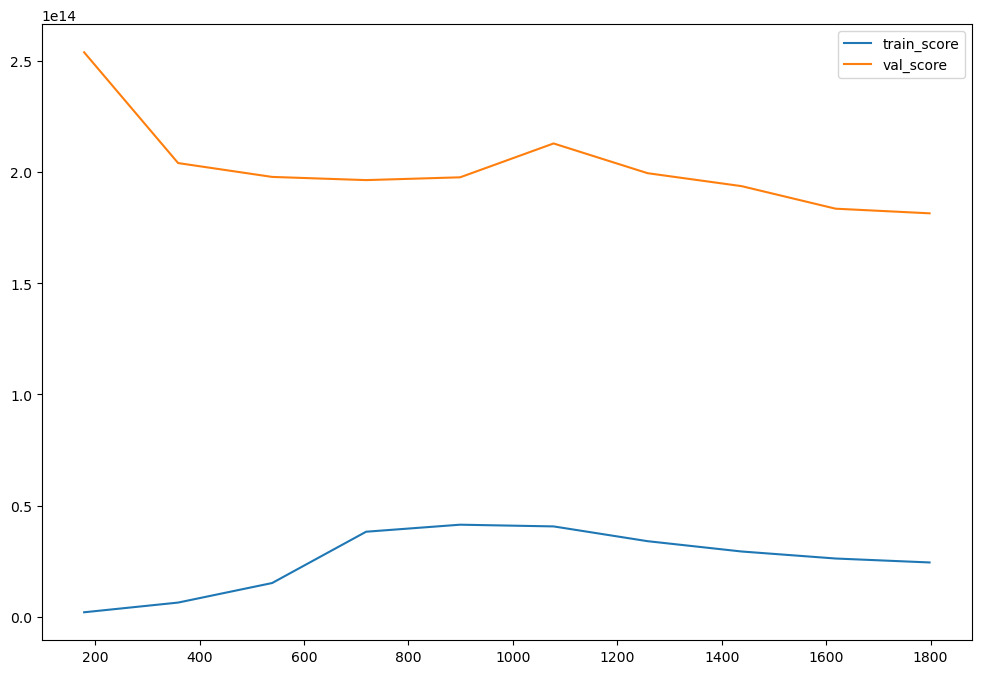

In [124]:
evaluation(model)

## Pipeline d'évaluation des modèles

In [125]:
preprocessor = make_pipeline(PolynomialFeatures(2), SelectKBest(k=7, score_func=f_regression))

In [126]:
ArbreRegression = make_pipeline(preprocessor, DecisionTreeRegressor(random_state = 100))
Random_Forest = make_pipeline(preprocessor, RandomForestRegressor(random_state = 100))
AdaBosst = make_pipeline(preprocessor, AdaBoostRegressor(random_state=100))
Regression_Linear = make_pipeline(preprocessor, StandardScaler(), LinearRegression())
Dummy_Regressor = make_pipeline(preprocessor, DummyRegressor())

In [127]:
list_models = {"ArbreRegression\n": ArbreRegression,
               "Random_Forest \n": Random_Forest, 
               "AdaBosst\n": AdaBosst,
               "Regression_Linear\n": Regression_Linear, 
               "Dummy_Regressor\n": Dummy_Regressor
              }



 ArbreRegression

Mean Absolute Error: 1852342.48
Mean Squared Error: 13849228363447.44
R-squared scores: 0.6


 Random_Forest 

Mean Absolute Error: 1552828.33
Mean Squared Error: 10716993794087.94
R-squared scores: 0.69


 AdaBosst

Mean Absolute Error: 3788664.36
Mean Squared Error: 36300928980162.74
R-squared scores: -0.06


 Regression_Linear

Mean Absolute Error: 2175980.38
Mean Squared Error: 18698657260565.19
R-squared scores: 0.45


 Dummy_Regressor

Mean Absolute Error: 4371658.44
Mean Squared Error: 36235306360148.88
R-squared scores: -0.06


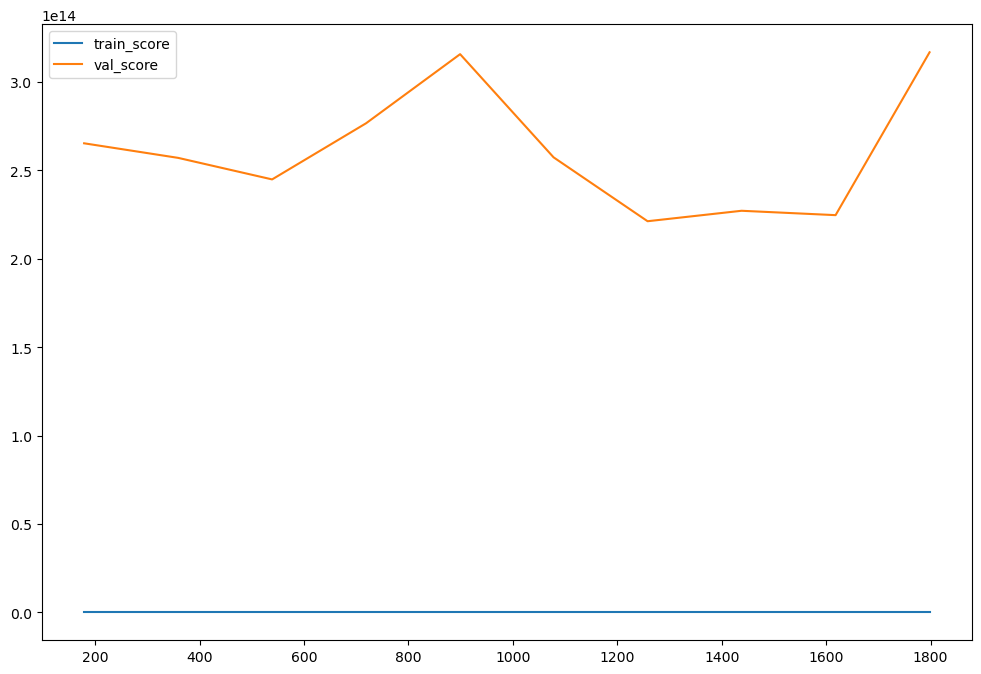

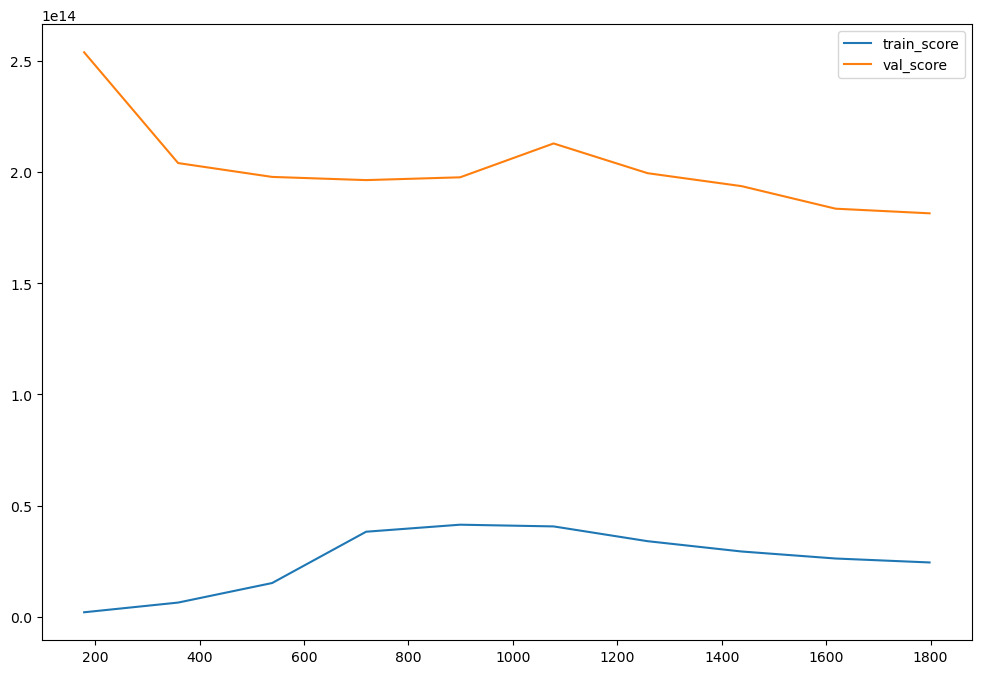

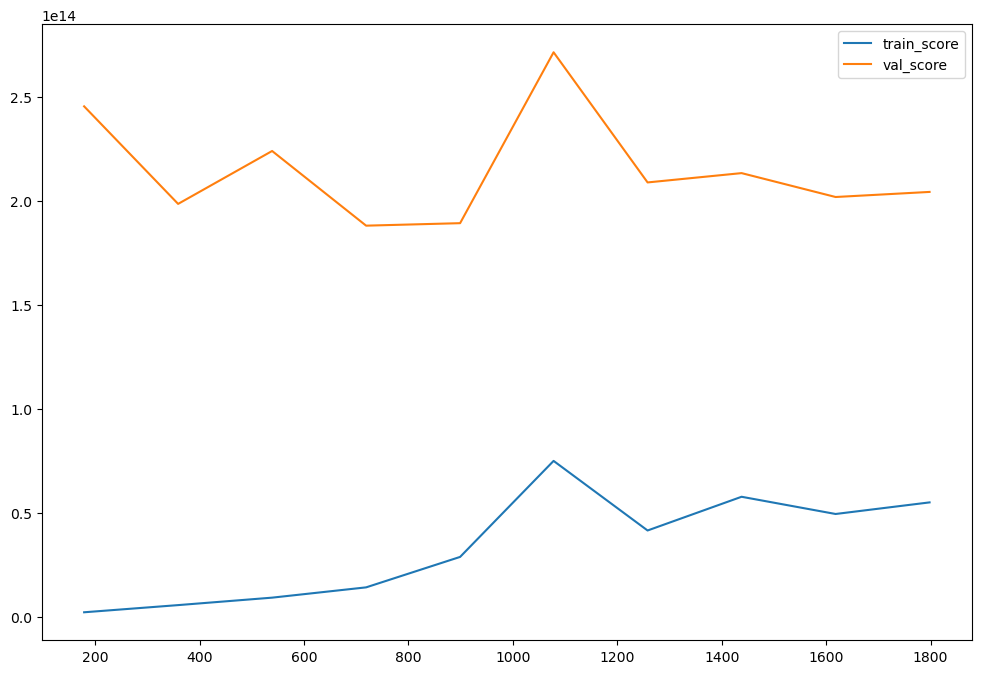

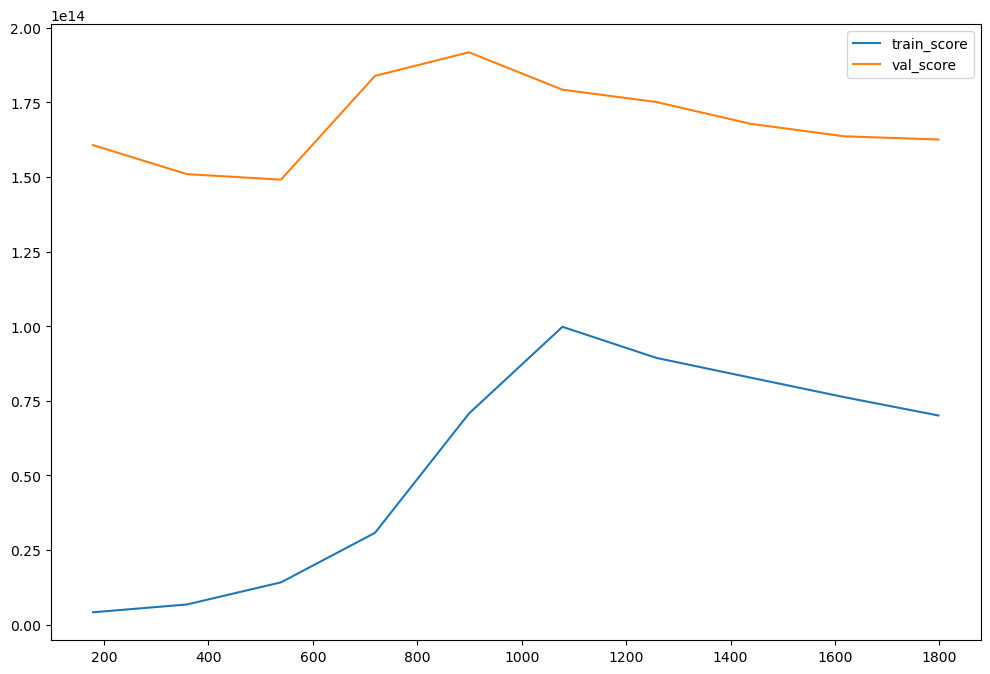

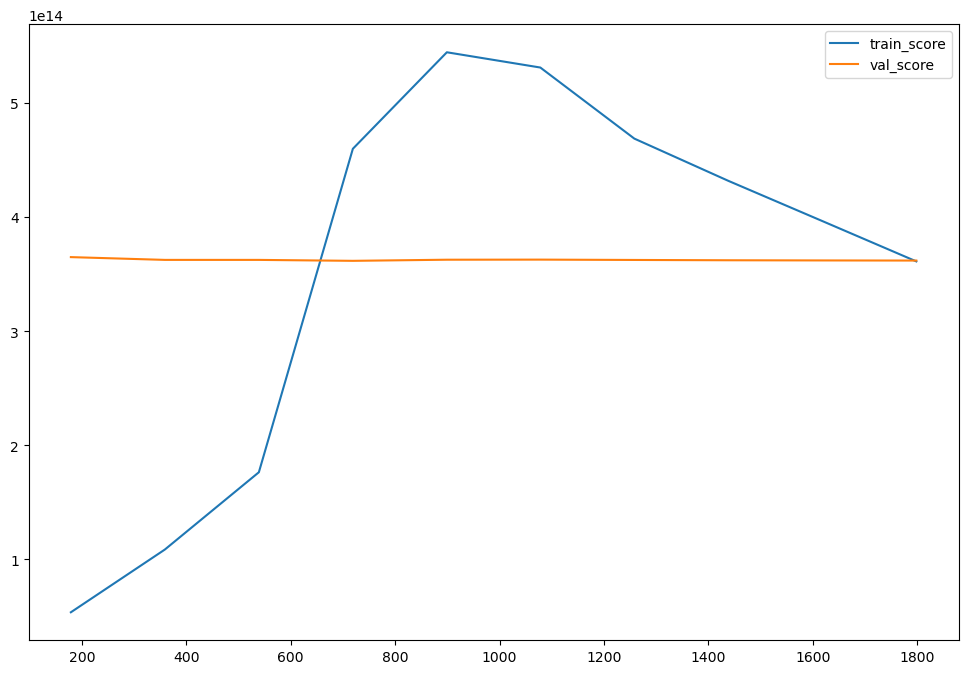

In [128]:
for name, value in list_models.items():
    print('\n\n',name)
    evaluation(value)

## Optimisation du modèle
### Recherche des Hyperparametres optimaux par la GridSearchCV

In [129]:
from sklearn.model_selection import GridSearchCV

In [130]:
Random_Forest 

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                                 ('selectkbest',
                                  SelectKBest(k=7,
                                              score_func=<function f_regression at 0x0000015F310D55E0>))])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=100))])

In [132]:
param_grid = {
    'randomforestregressor__max_depth': [30, 40, 50, 70],
    'randomforestregressor__max_features': [6, 7, 8, 9],
    'randomforestregressor__n_estimators': [80, 200, 400, 700]
}

In [133]:
# Instanciation du modèle de recherche par grille
grid_search = GridSearchCV(Random_Forest, param_grid, scoring = 'r2', cv = 3, n_jobs = -1, verbose = 2)

In [134]:
def evaluation(grid_search):
    grid_search.fit(X_train, y_train.values.ravel())
    predictions = grid_search.predict(X_test)
    mae = mean_absolute_error(y_test.values.ravel(), predictions)
   #Erreur quadratique moyenne (MSE)
    mse = mean_squared_error(y_test.values.ravel(), predictions)
   #Scores-R au carré
    r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
    print('Mean Absolute Error:', round(mae, 2))
    print('Mean Squared Error:', round(mse, 2))
    print('R-squared scores:', round(r2, 2))
    N, train_score, val_score = learning_curve(model, X_train, y_train, 
                                        cv=10, scoring = 'neg_mean_squared_error',
                                        train_sizes = np.linspace(0.1, 1, 10))
    plt.figure(figsize=(12, 8))
    plt.plot(N, -train_score.mean(axis = 1), label='train_score')
    plt.plot(N, -val_score.mean(axis = 1), label='val_score')
   # plt.ylabel('MSE', fontsize = 14)
   # plt.xlabel('Training set size', fontsize = 14)
    plt.legend()

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Mean Absolute Error: 1517331.57
Mean Squared Error: 10127943538582.5
R-squared scores: 0.7


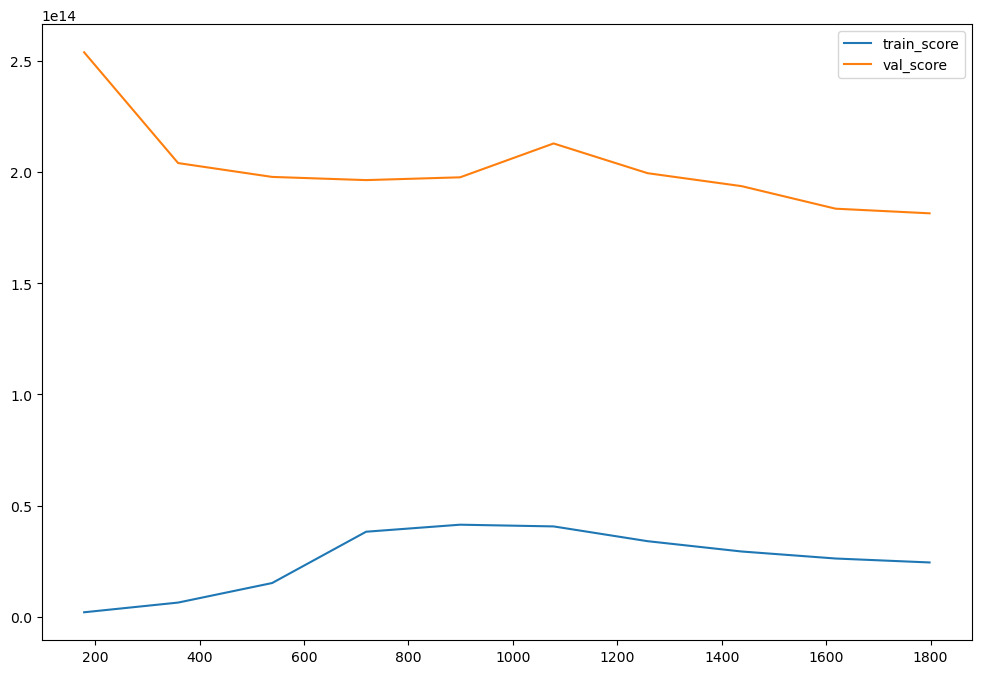

In [135]:
evaluation(grid_search)